In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import StratifiedKFold
from dateutil.relativedelta import relativedelta

In [7]:
train_data = pd.read_csv('./train_dataset/train_public.csv')
test_public = pd.read_csv('./test_public.csv')
train_internet = pd.read_csv('./train_dataset/train_internet.csv')

In [20]:
data1 = train_data.columns

In [21]:
data2 = train_internet.columns

In [23]:
diff1 = set(data1).difference(data2)
diff2 = set(data2).difference(data1)
print(diff1)
print(diff2)

{'isDefault', 'known_outstanding_loan', 'app_type', 'known_dero'}
{'offsprings', 'work_type', 'is_default', 'marriage', 'house_loan_status', 'sub_class', 'f5'}


In [8]:
train_data.T

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
loan_id,1040418,1025197,1009360,1039708,1027483,1047529,1030964,1024822,1008720,1045305,...,1028044,1046344,1040471,1009983,1047176,1028093,1043911,1023503,1024616,1021034
user_id,240418,225197,209360,239708,227483,247529,230964,224822,208720,245305,...,228044,246344,240471,209983,247176,228093,243911,223503,224616,221034
total_loan,31818.18182,28000.0,17272.72727,20000.0,15272.72727,25454.54545,9090.909091,10288.63636,6818.181818,10800.0,...,12763.63636,14181.81818,22909.09091,24545.45455,5318.181818,17727.27273,13636.36364,24818.18182,20000.0,1000.0
year_of_loan,3,5,3,3,3,3,5,3,3,3,...,5,3,5,5,3,3,3,3,3,3
interest,11.466,16.841,8.9,4.788,12.79,10.637,15.741,11.49,20.064,14.33,...,13.491,5.337,12.591,20.889,5.852,15.037,6.534,14.421,18.45,14.014
monthly_payment,1174.91,670.69,603.32,602.3,470.31,899.15,234.3,414.62,272.05,339.95,...,256.88,364.69,488.53,778.06,195.75,510.27,464.95,708.69,727.58,33.57
class,C,C,A,A,C,B,C,B,D,C,...,C,A,C,D,A,B,A,B,D,C
employer_type,政府机构,政府机构,政府机构,世界五百强,政府机构,幼教与中小学校,高等教育机构,普通企业,普通企业,幼教与中小学校,...,政府机构,幼教与中小学校,普通企业,普通企业,普通企业,普通企业,政府机构,普通企业,政府机构,高等教育机构
industry,金融业,金融业,公共服务、社会组织,文化和体育业,信息传输、软件和信息技术服务业,信息传输、软件和信息技术服务业,金融业,制造业,金融业,住宿和餐饮业,...,批发和零售业,电力、热力生产供应业,采矿业,电力、热力生产供应业,文化和体育业,建筑业,农、林、牧、渔业,信息传输、软件和信息技术服务业,农、林、牧、渔业,信息传输、软件和信息技术服务业
work_year,3 years,10+ years,10+ years,6 years,< 1 year,10+ years,10+ years,2 years,NaN,4 years,...,10+ years,10+ years,3 years,2 years,NaN,7 years,2 years,10+ years,10+ years,7 years


In [9]:
print(train_data.shape)
train_dedup = train_data.drop_duplicates()
print(train_dedup.shape)

(10000, 39)
(10000, 39)


In [53]:
def autolabel(arrayA):
    ''' label each colored square with the corresponding data value. 
    If value > 20, the text is in black, else in white.
    '''
    arrayA = np.array(arrayA)
    for i in range(arrayA.shape[0]):
        for j in range(arrayA.shape[1]):
                plt.text(j,i, "%.2f"%arrayA[i,j], ha='center', va='bottom',color='w')

def hist_it(feat):
    plt.figure(figsize=(16,4))
    feat[Y_train==0].hist(bins=range(int(feat.min()),int(feat.max()+2)),density=True,stacked=True,alpha=0.8)
    feat[Y_train==1].hist(bins=range(int(feat.min()),int(feat.max()+2)),density=True,stacked=True,alpha=0.5)
    plt.ylim((0,1))
    
def gt_matrix(feats,sz=16):
    a = []
    for i,c1 in enumerate(feats):
        b = [] 
        for j,c2 in enumerate(feats):
            mask = (~train_data[c1].isnull()) & (~train_data[c2].isnull())
            if i>=j:
                b.append((train_data.loc[mask,c1].values>=train_data.loc[mask,c2].values).mean())
            else:
                b.append((train_data.loc[mask,c1].values>train_data.loc[mask,c2].values).mean())

        a.append(b)
    print(a)
    plt.figure(figsize = (sz,sz))
    plt.imshow(a, interpolation = 'None')
    _ = plt.xticks(range(len(feats)),feats,rotation = 90)
    _ = plt.yticks(range(len(feats)),feats,rotation = 0)
    autolabel(a)

In [25]:
def hist_it1(feat):
    plt.figure(figsize=(16,4))
    feat[Y==0].hist(bins=100,range=(feat.min(),feat.max()),density=True,stacked=True,alpha=0.5)
    feat[Y==1].hist(bins=100,range=(feat.min(),feat.max()),density=True,stacked=True,alpha=0.5)
    plt.ylim((0,1))

In [14]:
train_data['is_train'] = 2
train_internet['is_train'] = 1
test_public['is_train']= 0
print(train_data.shape)
print(train_internet.shape)
print(test_public.shape)

(10000, 40)
(750000, 43)
(5000, 39)


In [11]:
X_train = pd.concat([train_data, train_internet], axis = 0)
X_train = pd.concat([X_train, test_public], axis = 0)

In [12]:
X_train.shape

(765000, 47)

In [29]:
# 列出所有含有null值的列
train_data.isnull().sum(axis=0).head(15)  

loan_id              0
user_id              0
total_loan           0
year_of_loan         0
interest             0
monthly_payment      0
class                0
employer_type        0
industry             0
work_year          622
house_exist          0
censor_status        0
issue_date           0
use                  0
post_code            0
dtype: int64

In [30]:
# 统计每个特征的值
# `dropna = False` makes nunique treat NaNs as a distinct value
feats_counts = train_data.nunique(dropna = False)  
 # 列出只有一个值的列
feats_counts.sort_values()[:10] 

is_train               1
policy_code            1
isDefault              2
app_type               2
initial_list_status    2
year_of_loan           2
censor_status          3
f1                     3
house_exist            5
employer_type          6
dtype: int64

In [31]:
constant_features = [c for c in feats_counts.loc[feats_counts==1].index.tolist() if c != 'is_train']
print(constant_features)

['policy_code']


In [32]:
train_data.drop(constant_features,axis = 1,inplace=True)
train_data.shape

(10000, 39)

In [33]:
# 空值填充
train_data.fillna(-1, inplace=True)

In [34]:
# 对每个列进行编码
# 生成mapping
train_data_enc = pd.DataFrame(index = train_data.index)
for col in train_data.columns:
    train_data_enc[col] = train_data[col].factorize()[0]

In [37]:
train_data_enc.head

<bound method NDFrame.head of       loan_id  user_id  total_loan  year_of_loan  interest  monthly_payment  \
0           0        0           0             0         0                0   
1           1        1           1             1         1                1   
2           2        2           2             0         2                2   
3           3        3           3             0         3                3   
4           4        4           4             0         4                4   
...       ...      ...         ...           ...       ...              ...   
9995     9995     9995          25             0       262              635   
9996     9996     9996          82             0       359             3285   
9997     9997     9997          31             0        60             6375   
9998     9998     9998           3             0       604             6376   
9999     9999     9999         262             0       334             4669   

      class  employer

In [35]:
dup_cols = {}

for i, c1 in enumerate(train_data_enc.columns):
    for c2 in train_data_enc.columns[i + 1:]:
        if c2 not in dup_cols and np.all(train_data_enc[c1] == train_data_enc[c2]):
            dup_cols[c2] = c1

In [36]:
dup_cols

{'user_id': 'loan_id'}

In [39]:
# 删除重复列
train_data.drop(dup_cols.keys(), axis = 1,inplace=True)

In [40]:
# 唯一值统计
nunique = train_data.nunique(dropna=False)
nunique

loan_id                     10000
total_loan                   1632
year_of_loan                    2
interest                     1028
monthly_payment              6377
class                           7
employer_type                   6
industry                       14
work_year                      12
house_exist                     5
censor_status                   3
issue_date                    127
use                            14
post_code                     794
region                         50
debt_loan_ratio              6213
del_in_18month                 12
scoring_low                   132
scoring_high                  361
known_outstanding_loan         47
known_dero                     13
pub_dero_bankrup                7
recircle_b                   9458
recircle_u                   3083
initial_list_status             2
app_type                        2
earlies_credit_mon            528
title                         908
f0                             30
f1            

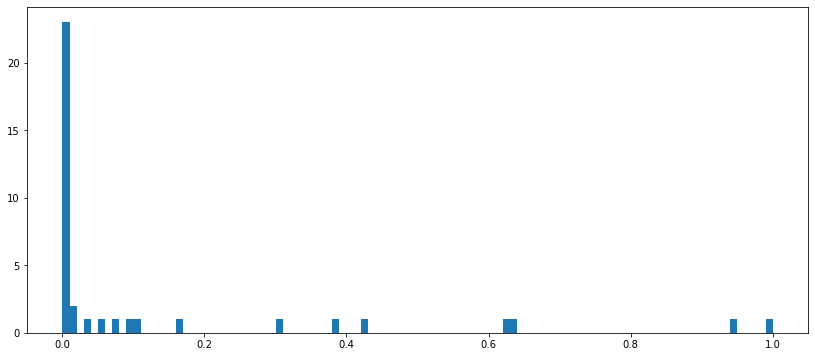

In [41]:
# 计算唯一值的数据占比
plt.figure(figsize=(14,6))
_ = plt.hist(nunique.astype(float)/train_data.shape[0], bins=100)

In [42]:
# 找到唯一值占比很大（即重复性少）的列
# 这些值基本都是整数，意味着他们是某种ID或者统计量（count）
mask = (nunique.astype(float)/train_data.shape[0] > 0.8)
train_data.loc[:, mask]

,loan_id,recircle_b
0,1040418,7734.230769
1,1025197,31329.000000
2,1009360,18514.000000
3,1039708,20707.000000
4,1027483,14016.153850
...,...,...
9995,1028093,19864.923080
9996,1043911,2025.000000
9997,1023503,12641.000000
9998,1024616,24642.692310


In [44]:
# 再看一下重复率相对少的列
# These look like counts too. 
# First thing to notice is the 23th line: 99999.., -99999 values look like NaNs so we should probably built a related feature. 
# Second: the columns are sometimes placed next to each other, so the columns are probably grouped together and we can disentangle that.      
# 要注意的点：异常值（比如-99999或者+99999）可能代表着NaN或者缺失数据
mask = (nunique.astype(float)/train_data.shape[0] < 0.8) & (nunique.astype(float)/train_data.shape[0] > 0.4)
train_data.loc[:25, mask]

,monthly_payment,debt_loan_ratio,early_return_amount
0,1174.91,2.430000,9927
1,670.69,11.004545,0
2,603.32,6.409091,0
3,602.30,9.204545,0
4,470.31,15.578182,0
5,899.15,15.807273,0
6,234.30,4.243636,0
7,414.62,2.227273,0
8,272.05,22.930909,0
9,339.95,21.223636,0


In [46]:
# Our conclusion: there are no floating point variables, there are some counts variables, which we will treat as numeric. 
# And finally, let's pick one variable (in this case 'VAR_0015') from the third group of features.

train_data['work_year'].value_counts()

10+ years    3370
2 years       848
3 years       776
< 1 year      765
1 year        671
5 years       623
-1            622
4 years       562
6 years       476
8 years       458
7 years       436
9 years       393
Name: work_year, dtype: int64

In [47]:
# 把分类型和数值型的特征分别跳出来
cat_cols = list(train_data.select_dtypes(include=['object']).columns)
num_cols = list(train_data.select_dtypes(exclude=['object']).columns)
print(cat_cols)
print(num_cols)

['class', 'employer_type', 'industry', 'work_year', 'issue_date', 'earlies_credit_mon']
['loan_id', 'total_loan', 'year_of_loan', 'interest', 'monthly_payment', 'house_exist', 'censor_status', 'use', 'post_code', 'region', 'debt_loan_ratio', 'del_in_18month', 'scoring_low', 'scoring_high', 'known_outstanding_loan', 'known_dero', 'pub_dero_bankrup', 'recircle_b', 'recircle_u', 'initial_list_status', 'app_type', 'title', 'f0', 'f1', 'f2', 'f3', 'f4', 'early_return', 'early_return_amount', 'early_return_amount_3mon', 'isDefault', 'is_train']


In [49]:
len(num_cols)

32

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9997, 1.0, 1.0, 1.0, 0.521, 1.0, 1.0, 1.0, 0.9504, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.9998, 1.0, 0.7064, 0.0092, 0.0904, 0.0299, 0.9772, 0.0, 0.0, 0.0107, 0.9908, 0.9987, 0.0054, 0.0192, 1.0, 1.0, 0.5572, 0.2346, 1.0, 0.2377, 0.0618, 0.1482, 0.7326, 0.3866, 0.5372, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.9917, 0.0308, 0.4476, 0.3336, 0.9996, 0.0, 0.0, 0.6107, 0.9997, 1.0, 0.0061, 0.056, 1.0, 1.0, 0.8469, 0.9334, 1.0, 0.7778, 0.5116, 0.796, 1.0, 0.3866, 0.5405, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7106, 0.9995, 0.9998, 1.0, 0.1815, 0.1209, 1.0, 1.0, 1.0, 0.0129, 0.9894, 1.0, 1.0, 0.9082, 1.0, 1.0, 0.9999, 0.9999, 1.0, 1.0, 0.419, 0.7108, 1.0, 1.0], [0.0, 0.0, 0.0002, 0.0, 0.0, 1.0, 0.1954, 0

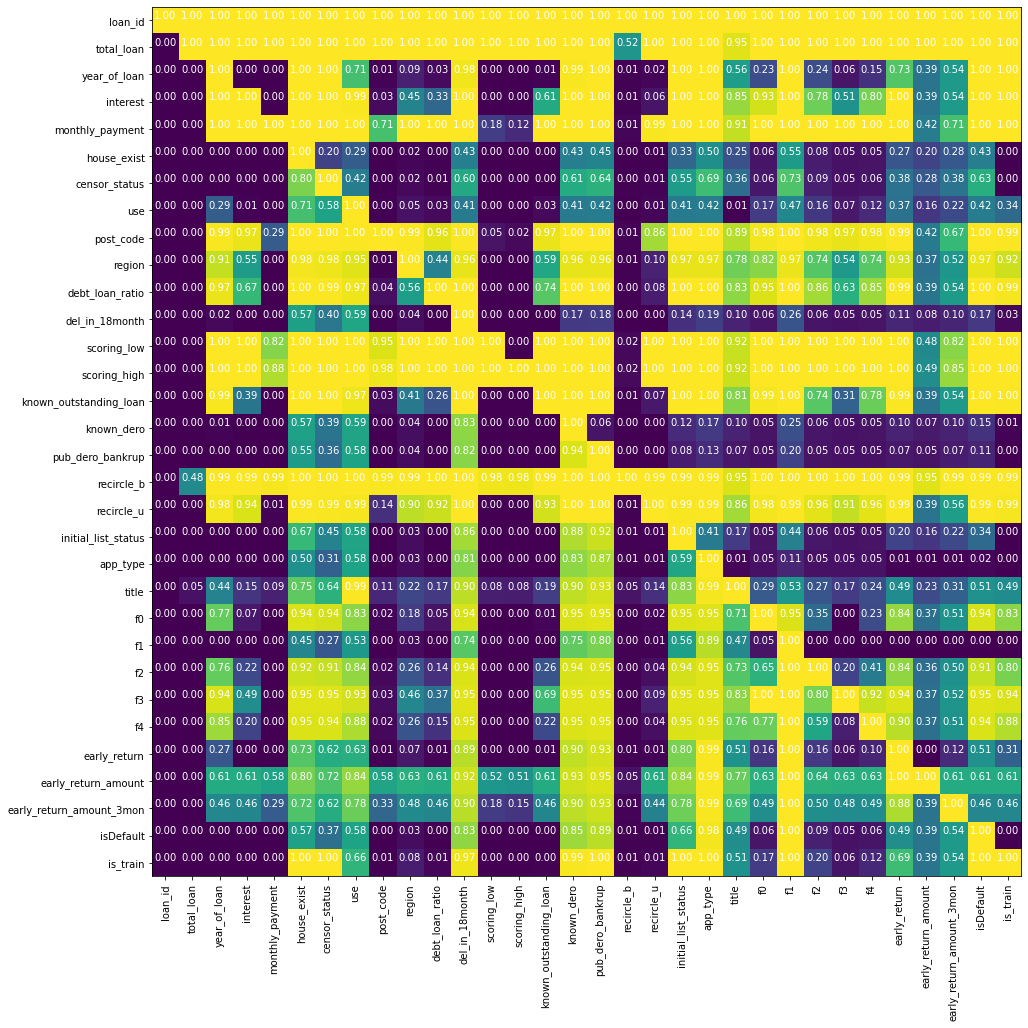

In [54]:
# select first 42 numeric features
feats = num_cols[:32]

# build 'mean(feat1 > feat2)' plot
gt_matrix(feats,16)

In [55]:
# 分类型特征
train_data.loc[:,cat_cols].head().T

,0,1,2,3,4
class,C,C,A,A,C
employer_type,政府机构,政府机构,政府机构,世界五百强,政府机构
industry,金融业,金融业,公共服务、社会组织,文化和体育业,信息传输、软件和信息技术服务业
work_year,3 years,10+ years,10+ years,6 years,< 1 year
issue_date,2016/10/1,2013/6/1,2014/1/1,2015/7/1,2016/7/1
earlies_credit_mon,2021/12/1,1990/4/1,1991/10/1,2021/6/1,2021/5/2


In [56]:
for c in cat_cols:
    print(c)
    print(train_data[c].value_counts())

class
B    2965
C    2859
A    1698
D    1483
E     693
F     241
G      61
Name: class, dtype: int64
employer_type
普通企业       4610
政府机构       2474
幼教与中小学校    1053
上市企业        958
世界五百强       542
高等教育机构      363
Name: employer_type, dtype: int64
industry
金融业                1629
电力、热力生产供应业         1248
公共服务、社会组织          1065
住宿和餐饮业              907
信息传输、软件和信息技术服务业     808
文化和体育业              793
建筑业                 704
房地产业                554
采矿业                 506
交通运输、仓储和邮政业         492
农、林、牧、渔业            466
制造业                 302
批发和零售业              279
国际组织                247
Name: industry, dtype: int64
work_year
10+ years    3370
2 years       848
3 years       776
< 1 year      765
1 year        671
5 years       623
-1            622
4 years       562
6 years       476
8 years       458
7 years       436
9 years       393
Name: work_year, dtype: int64
issue_date
2016/3/1     374
2015/10/1    335
2015/7/1     326
2015/12/1    304
2014/10/1    281
            ... 
2007/10/1  